# Negation detection with ConText

## Setup

In [1]:
import pathlib
import pickle
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from spacy import displacy
import medspacy
from medspacy.visualization import visualize_dep
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from collections import defaultdict
from build_pipeline import build_pipeline
# until bug is fixed in v6 of ipython kernel
import warnings
warnings.simplefilter('once')

## Load

In [2]:
rootf = pathlib.Path.cwd().parents[0]

/home/lcreteig/negation-detection/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Texts and annotations

In [3]:
# DCC texts + annotations
annotation_file = rootf / 'data' / 'emc-dcc_ann.json'

In [4]:
# Load annotated data
with open(annotation_file) as f:
    annotations = json.load(f)

### Files to skip

In [5]:
skip_file = rootf / 'utils' / 'DCC_files_to_exclude.json'

In [6]:
# Some files should be skipped because of annotation errors, missing annotations, or corrupted contents
with open(skip_file) as json_file:
    problem_files = json.load(json_file)
    skip_files = [f['name'] for k, v in problem_files.items() for f in v]

### Cross-validation splits

In [7]:
split_list_file = rootf / 'data' / 'split_list.json'

In [8]:
# Load split lists
with open(split_list_file) as f:
    split_lists = json.load(f)

split_list = split_lists[0]

### Rule-based pipeline

In [9]:
# set of rules
context_file = rootf / 'rule-based_context' / 'configs' / 'context' / 'contextD_triggers.json'

In [10]:
# assemble the pipeline
nlp = build_pipeline(str(context_file))

## Run pipeline

In [11]:
%%time
docs = []
for document in annotations['projects'][0]['documents']:
    document_name = document['name']
    text = document['text']
    
    if document_name not in skip_files:
    
        pipeline_params = {
            "labeller": {"starts": [ann['start'] for ann in document['annotations']], 
                         "ends":  [ann['end'] for ann in document['annotations']],
                         "labels": [ann['meta_anns']['Negation']['value'] for ann in document['annotations']],
                         "doc_id": document_name}
            }

        doc = nlp(text, component_cfg = pipeline_params)
        docs.append(doc)

CPU times: user 20.3 s, sys: 114 ms, total: 20.4 s
Wall time: 20.4 s


## Example

In [12]:
[example_doc] = [d for d in docs if d._.doc_id == 'DL1112']

In [13]:
displacy.render(example_doc, style='ent')

In [14]:
visualize_dep(example_doc)

## Score performance

### Negation

Table of all predictions:

In [15]:
result_file = rootf /  'results' / 'rule-based_predictions.csv.gz'

In [16]:
res = []
for d in docs:
    for e in d.ents:
        res.append({'entity_id': e._.entity_id,
                    'annotation': e._.negation,
                    'rule_based': 'negated' if e._.is_negated else 'not negated'})
pd.DataFrame(res).to_csv(result_file, index=False, compression='gzip')

#### Total

In [17]:
trues = [True if e._.negation=='negated' else False for d in docs for e in d.ents]
preds = [e._.is_negated for d in docs for e in d.ents]
target_names = ['not negated', 'negated']

In [18]:
print(classification_report(trues, preds, target_names=target_names))

              precision    recall  f1-score   support

 not negated       0.98      0.97      0.98     10791
     negated       0.82      0.89      0.86      1760

    accuracy                           0.96     12551
   macro avg       0.90      0.93      0.92     12551
weighted avg       0.96      0.96      0.96     12551



#### Per document type

In [19]:
data_types = ['GP', 'SP', 'RD', 'DL']
results = defaultdict(list)
for dt in data_types:
    trues = [True if e._.negation=='negated' else False for d in docs if d._.doc_id.startswith(dt) for e in d.ents]
    trues_all = [(True, e,i,j) if e._.negation=='negated' else (False,e,i,j) 
                                                                 for i,d in enumerate(docs)
                                                                 if d._.doc_id.startswith(dt)
                                                                 for j,e in enumerate(d.ents) 
                                                                  ]
    preds = [e._.is_negated for d in docs if d._.doc_id.startswith(dt) for e in d.ents]
    preds_all = [(True, e, i,j) if e._.is_negated else (False, e, i,j) 
                                                                 for i,d in enumerate(docs)
                                                                 if d._.doc_id.startswith(dt)                                                                  
                                                                 for j,e in enumerate(d.ents)
                                                                 ]
    
    results[dt] = {'trues': trues_all, 'preds': preds_all}
    
    print(f"Data type: {dt}")
    print(classification_report(trues, preds, target_names=target_names))

Data type: GP
              precision    recall  f1-score   support

 not negated       0.97      0.95      0.96      3013
     negated       0.67      0.80      0.73       383

    accuracy                           0.93      3396
   macro avg       0.82      0.88      0.85      3396
weighted avg       0.94      0.93      0.94      3396



/home/lcreteig/negation-detection/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Data type: SP
              precision    recall  f1-score   support

 not negated       0.97      0.96      0.97      2273
     negated       0.81      0.84      0.82       403

    accuracy                           0.95      2676
   macro avg       0.89      0.90      0.89      2676
weighted avg       0.95      0.95      0.95      2676

Data type: RD
              precision    recall  f1-score   support

 not negated       0.99      0.98      0.99      3088
     negated       0.90      0.97      0.93       595

    accuracy                           0.98      3683
   macro avg       0.95      0.97      0.96      3683
weighted avg       0.98      0.98      0.98      3683

Data type: DL
              precision    recall  f1-score   support

 not negated       0.99      0.98      0.99      2417
     negated       0.89      0.92      0.91       379

    accuracy                           0.97      2796
   macro avg       0.94      0.95      0.95      2796
weighted avg       0.97      0.9

Compare to paper: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-014-0373-3/tables/5

- **GP**: 
    - Precision and recall much worse than in paper. Probably because we haven't added the GP-specific tweaks for the rules yet?
    - Also here recall is higher than precision; other way around in paper (for baseline)
- **SP**: Performance pretty similar (couple points worse)
- **RD**: Performance almost exactly the same as in paper (for final)
- **DL**: Performance pretty similar (bit worse)

## Failure modes

In [20]:
false_negatives = dict()
false_positives = dict()
false_negatives['GP'] = [t for i,t in enumerate(results['GP']['trues']) if (t[0]!=results['GP']['preds'][i][0]) &\
                                                                           (t[0]==True)]
false_positives['GP'] = [t for i,t in enumerate(results['GP']['trues']) if (t[0]!=results['GP']['preds'][i][0]) &\
                                                                           (t[0]==False)]

/home/lcreteig/negation-detection/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
n = 10
false_negatives['GP'][n], displacy.render(docs[false_negatives['GP'][n][2]], style='ent')

((True, zwelling, 1295, 0), None)

## Cross-validation

In [22]:
def compute_metrics(_trues, _preds):
    metrics = {'f1': f1_score(_trues, _preds),
               'accuracy': accuracy_score(_trues, _preds),
               'recall': recall_score(_trues, _preds),
               'specificity': recall_score(_trues, _preds, pos_label = False),
               'precision': precision_score(_trues, _preds),
               'NPV': precision_score(_trues, _preds, pos_label = False)}
    return metrics

In [23]:
metrics_list = []
for i in range(len(split_lists)): # for each test set
    test_set = split_lists[i]['test']
    for dt in data_types: # for each document type
        # whether entity is truly negated
        _trues = [True if e._.negation=='negated' else False for d in docs # for each doc
                 if (d._.doc_id.startswith(dt) and d._.doc_id in test_set) # that's of current type and is in the test set
                 for e in d.ents] # for each entity in that doc
        # whether negation rules are met
        _preds = [e._.is_negated for d in docs 
                  if (d._.doc_id.startswith(dt) and d._.doc_id in test_set)
                  for e in d.ents]
        res = compute_metrics(_trues,_preds)
        res['doc_type'] = dt
        res['fold'] = i
        metrics_list.append(res)
        
scores = pd.DataFrame(metrics_list)

In [24]:
scores.drop(columns='fold').groupby('doc_type').mean()

/home/lcreteig/negation-detection/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,f1,accuracy,recall,specificity,precision,NPV
doc_type,,,,,,
DL,0.901136,0.973793,0.919285,0.982457,0.886968,0.987246
GP,0.732929,0.933349,0.806927,0.949694,0.676582,0.974520
RD,0.930651,0.977616,0.966075,0.979849,0.899528,0.993389
SP,0.821030,0.945697,0.840368,0.965658,0.810091,0.970466


### Visualize scores

In [25]:
scores_melt = scores.melt(id_vars = ['fold', 'doc_type'], value_vars = ['f1', 'accuracy', 'recall', 'specificity', 'precision', 'NPV'], var_name = 'metric')

/home/lcreteig/negation-detection/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


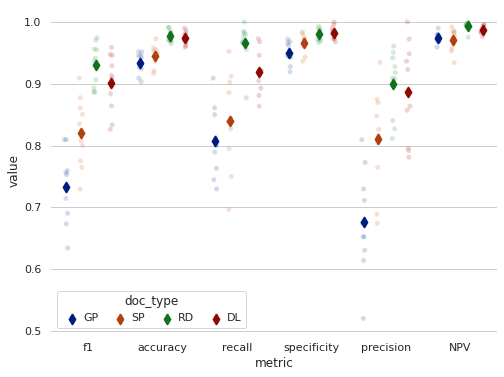

In [26]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(8,6))
sns.despine(bottom=True, left=True)

# scatter
sns.stripplot(x="metric", y="value", hue="doc_type",
              data=scores_melt, dodge=True, alpha=.25, zorder=1)

# means
sns.pointplot(x="metric",  y="value", hue="doc_type",
              data=scores_melt, dodge=.8 - .8 / 4,
              join=False, palette="dark",
              markers="d", scale=1, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title="doc_type",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=4, frameon=True);